In [1]:
%matplotlib notebook

# Specify CUDA device
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = 'gpu'

from jax import jit, config, grad
config.update("jax_enable_x64", True)

# Check we're running on GPU
# from jax.lib import xla_bridge
# print(xla_bridge.get_backend().platform)

import time
import numpy as np
import jax.numpy as jnp
import optax
import jaxopt

from matplotlib import pyplot as plt
from importlib import reload

import scatcovjax.Sphere_lib as sphlib
import scatcovjax.Synthesis_lib as synlib
import scatcovjax.Scattering_lib as scatlib
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav

import scatcovjax.plotting as plot
plot.notebook_plot_format()

# Parameters

In [2]:
sampling = "mw"
multiresolution = True
reality = True
norm = None

L = 350
N = 1
J_min = 0

J = s2wav.utils.shapes.j_max(L)
print(f'{J=}')


J=9


# Filters

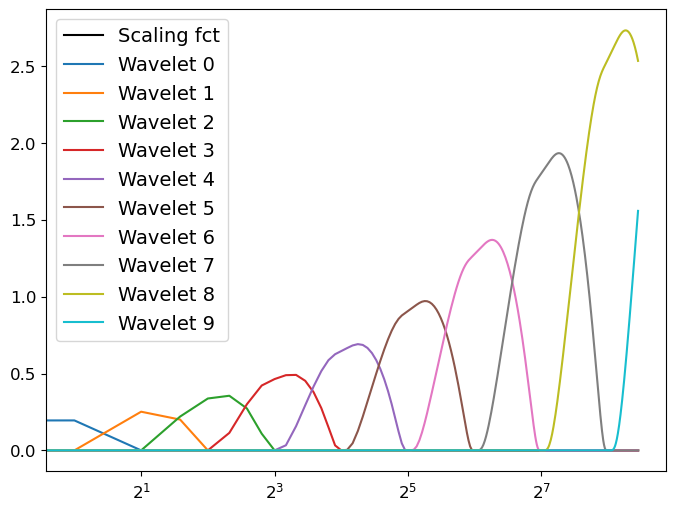

In [25]:
filters = filters_directional_vectorised(L, N, J_min)
plot.plot_filters(filters, real=True, m=L-1)

filters=filters[0]

# Weights and precomps

In [26]:
weights = scatlib.quadrature(L, J_min, sampling, None, multiresolution)

precomps = s2wav.transforms.jax_wavelets.generate_wigner_precomputes(L, N, J_min, 2.0, sampling, None, False,
                                                                     reality, multiresolution)


# Target map

In [27]:
### Sky
f_target, flm_target = sphlib.make_MW_lensing(L, normalize=True, reality=reality)
print('Target = LSS map')

#f_target, flm_target = sphlib.make_pysm_sky(L, 'cmb', sampling=sampling, nest=False, normalize=True, reality=reality)
#print('Target = CMB map')

# f_target, flm_target = sphlib.make_planet(L, planet, normalize=True, reality=reality)
# print('Target = Planet map')



Target = LSS map


In [28]:
### Power spectrum of the target
ps_target = sphlib.compute_ps(flm_target)

### Scat coeffs S1, P00, C01, C11
# tP00 is one by definition of the normalisation
tcoeffs = scatlib.scat_cov_dir(flm_target, L, N, J_min, sampling, None,
                       reality, multiresolution, normalisation=norm,
                       filters=filters, quads=weights, precomps=precomps)
tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs

3 (1, 4, 7)
3 (1, 4, 7)
4 (1, 4, 7)
5 (1, 4, 7)
6 (1, 4, 7)
7 (1, 4, 7)
8 (1, 4, 7)
9 (1, 4, 7)
10 (1, 4, 7)
10 (1, 4, 7)
(9, 9, 1, 1, 1)
(8, 8, 1, 1, 1)
(7, 7, 1, 1, 1)
(6, 6, 1, 1, 1)
(5, 5, 1, 1, 1)
(4, 4, 1, 1, 1)
(3, 3, 1, 1, 1)
(2, 2, 1, 1, 1)
(1, 1, 1, 1, 1)


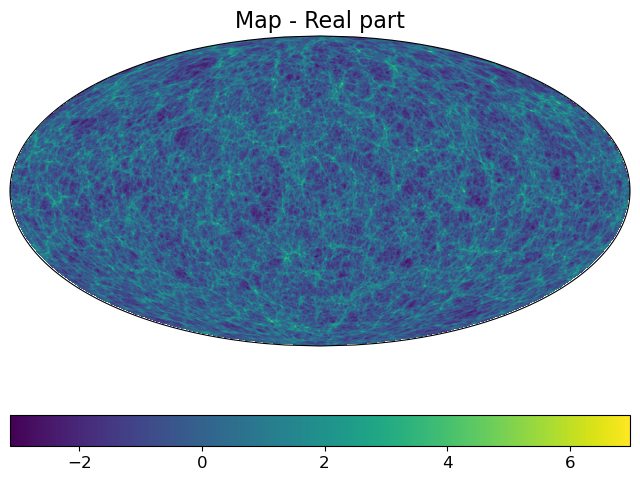

In [29]:
# Plot the map
mx, mn = np.nanmax(np.real(f_target)), np.nanmin(np.real(f_target))
plot.plot_map_MW_Mollweide(np.real(f_target), figsize=(8, 6), vmin=mn, vmax=mx)

# Define the loss

In [30]:
@jit
def loss_func_ps_only(flm):
    ps = sphlib.compute_ps(flm)
    loss = synlib.chi2(ps_target, ps)
    return loss


@jit
def loss_func_P00_only(flm):
    P00_new = scatlib.get_P00only(flm, L, N, J_min, sampling,
                          None, reality, multiresolution,
                          normalisation=norm, filters=filters,
                          quads=weights, precomps=precomps)
    loss = synlib.chi2(tP00, P00_new)
    return loss



@jit
def loss_func(flm):
    mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scatlib.scat_cov_dir(flm, L, N, J_min, sampling,
                                                                        None, reality, multiresolution,
                                                                        normalisation=norm, filters=filters,
                                                                        quads=weights, precomps=precomps)
    # Control for mean + var
    loss = synlib.chi2(tmean, mean_new)
    loss += synlib.chi2(tvar, var_new)

    # Add S1, P00, C01, C11 losses
    loss += synlib.chi2(tS1, S1_new)
    loss += synlib.chi2(tP00, P00_new)
    loss += synlib.chi2(tC01, C01_new)
    loss += synlib.chi2(tC11, C11_new)

    return loss


# Initial condition

In [31]:
# Gaussian white noise in pixel space
print(f'{tvar=}')
f = np.sqrt(tvar) * np.random.randn(L, 2 * L - 1).astype(np.float64)
flm = s2fft.forward_jax(f, L, reality=reality)

# Cut the flm
flm = flm[:, L - 1:] if reality else flm

flm_start = jnp.copy(flm)  # Save the start point as we will iterate on flm

tvar=Array(0.99618435, dtype=float64)


# Run the synthesis

### Gradient descent à la main

- Si je ne mets pas le conjugué, ça diverge.
- Avec le conjugué, ça descend lentement et le PS et la carte ne changent pas bcp

In [216]:
def fit_brutal(params, loss_func, momentum: float = 2., niter: int = 10, loss_history: list = None):
    ### Gradient of the loss function
    grad_loss_func = jit(grad(loss_func))

    if loss_history is None:
        loss_history = []
    for i in range(niter):
        start = time.time()
        params -= momentum * np.conj(grad_loss_func(params))
        #params -= momentum * grad_loss_func(params)
        if i % 10 == 0:
            end = time.time()
            loss_value = loss_func(params)
            loss_history.append(loss_value)
            print(f"Iter {i}: Loss = {loss_value:.5f}, Momentum = {momentum}, Time = {end - start:.2f} s/iter")

    return params, loss_history

In [30]:
niter = 400
momentum = 4.
flm, loss_history = fit_brutal(flm, loss_func_P00_only, momentum=momentum, niter=niter, loss_history=None)

flm_end = jnp.copy(flm)

Iter 0: Loss = 0.00022, Momentum = 4.0, Time = 12.69 s/iter
Iter 10: Loss = 0.00022, Momentum = 4.0, Time = 0.03 s/iter
Iter 20: Loss = 0.00022, Momentum = 4.0, Time = 0.02 s/iter
Iter 30: Loss = 0.00023, Momentum = 4.0, Time = 0.02 s/iter
Iter 40: Loss = 0.00025, Momentum = 4.0, Time = 0.02 s/iter
Iter 50: Loss = 0.00029, Momentum = 4.0, Time = 0.02 s/iter
Iter 60: Loss = 0.00038, Momentum = 4.0, Time = 0.02 s/iter
Iter 70: Loss = 0.00077, Momentum = 4.0, Time = 0.02 s/iter
Iter 80: Loss = 0.05161, Momentum = 4.0, Time = 0.02 s/iter
Iter 90: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 100: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 110: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 120: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 130: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 140: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 150: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 160: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 

Iter 1430: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1440: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1450: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1460: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1470: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1480: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1490: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1500: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1510: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1520: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1530: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1540: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1550: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1560: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1570: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1580: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1590: Loss = inf, Momentum = 4.0, Time = 0.02 s/iter
Iter 1600: Los

### Using Optax

- Avec Adam, ca converge bien et le PS et la carte ont l'air ok

In [11]:
def fit_optax(params: optax.Params, optimizer: optax.GradientTransformation, loss_func,
              niter: int = 10, loss_history: list = None) -> optax.Params:
    ### Gradient of the loss function
    grad_func = jit(grad(loss_func))

    if loss_history is None:
        loss_history = []
    opt_state = optimizer.init(params)
    for i in range(niter):
        start = time.time()
        grads = jnp.conj(grad_func(params))  # Take the conjugate of the gradient
        #grads = grad_func(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        end = time.time()
        if i % 10 == 0:
            loss_value = loss_func(params)
            loss_history.append(loss_value)
            print(f'Iter {i}, Loss: {loss_value:.10f}, Time = {end - start:.10f} s/iter')

    return params, loss_history

In [32]:
niter = 150
lr = 1e-2
#optimizer = optax.fromage(lr)
optimizer = optax.adam(lr)
#optimizer = optax.adagrad(lr)
flm, loss_history = fit_optax(flm, optimizer, loss_func_P00_only, niter=niter, loss_history=None)

flm_end = jnp.copy(flm)

Iter 0, Loss: 0.0061571778, Time = 31.8247580528 s/iter
Iter 10, Loss: 0.0001990411, Time = 0.2086133957 s/iter
Iter 20, Loss: 0.0001452163, Time = 0.2081162930 s/iter
Iter 30, Loss: 0.0000091639, Time = 0.2085785866 s/iter
Iter 40, Loss: 0.0000075881, Time = 0.2081899643 s/iter
Iter 50, Loss: 0.0000028349, Time = 0.2086029053 s/iter
Iter 60, Loss: 0.0000007289, Time = 0.2085578442 s/iter
Iter 70, Loss: 0.0000000318, Time = 0.2085878849 s/iter
Iter 80, Loss: 0.0000000970, Time = 0.2081947327 s/iter
Iter 90, Loss: 0.0000000393, Time = 0.2086534500 s/iter
Iter 100, Loss: 0.0000000231, Time = 0.2081549168 s/iter
Iter 110, Loss: 0.0000000038, Time = 0.2084853649 s/iter
Iter 120, Loss: 0.0000000032, Time = 0.2082846165 s/iter
Iter 130, Loss: 0.0000000009, Time = 0.2084295750 s/iter
Iter 140, Loss: 0.0000000002, Time = 0.2080597878 s/iter


### Using Jaxopt

- Methods : GradientDescent ou LBFGS

- Ca diverge, quelque soit le stepsize que je mette

In [116]:
def fit_jaxopt(params, loss_func, method='LBFGS', stepsize=1e-2,
              niter: int = 10, loss_history: list = None):
    
    if method == 'LBFGS':
        optimizer = jaxopt.LBFGS(fun=loss_func, jit=True, stepsize=stepsize)
    elif method == 'GradientDescent':
        optimizer = jaxopt.GradientDescent(fun=loss_func, jit=True, stepsize=stepsize)
    
    if loss_history is None:
        loss_history = []
        loss_history.append(loss_func(params))
        
    opt_state = optimizer.init_state(params)
    for i in range(niter):
        start = time.time()
        params, opt_state = optimizer.update(params, opt_state)
        end = time.time()
        if i % 1 == 0:
            loss_value = loss_func(params)
            loss_history.append(loss_value)
            print(f'Iter {i}, Loss: {loss_value:.10f}, Time = {end - start:.10f} s/iter')

    return params, loss_history

In [117]:
flm, loss_history = fit_jaxopt(flm, loss_func_P00_only, method='LBFGS', niter=400, loss_history= None)

flm_end = jnp.copy(flm)

Iter 0, Loss: 0.0000181986, Time = 0.5810565948 s/iter
Iter 1, Loss: 0.0000181836, Time = 0.5635602474 s/iter
Iter 2, Loss: 0.0000181648, Time = 0.5745394230 s/iter
Iter 3, Loss: 0.0000181420, Time = 0.5473086834 s/iter
Iter 4, Loss: 0.0000181150, Time = 0.5680556297 s/iter
Iter 5, Loss: 0.0000180832, Time = 0.5736556053 s/iter
Iter 6, Loss: 0.0000180464, Time = 0.5671072006 s/iter
Iter 7, Loss: 0.0000180041, Time = 0.5603511333 s/iter
Iter 8, Loss: 0.0000179556, Time = 0.5739586353 s/iter
Iter 9, Loss: 0.0000179003, Time = 0.5753626823 s/iter
Iter 10, Loss: 0.0000178371, Time = 0.5664670467 s/iter
Iter 11, Loss: 0.0000177635, Time = 0.5727388859 s/iter
Iter 12, Loss: 0.0000176739, Time = 0.5597987175 s/iter
Iter 13, Loss: 0.0000175545, Time = 0.5724844933 s/iter
Iter 14, Loss: 0.0000173636, Time = 0.5485291481 s/iter
Iter 15, Loss: 0.0000170119, Time = 0.5457694530 s/iter
Iter 16, Loss: 0.0000165847, Time = 0.5688188076 s/iter
Iter 17, Loss: 0.0000156972, Time = 0.5769991875 s/iter
It

Iter 146, Loss: 0.0000067368, Time = 0.5833272934 s/iter
Iter 147, Loss: 0.0000067272, Time = 0.5879926682 s/iter
Iter 148, Loss: 0.0000067144, Time = 0.5754499435 s/iter
Iter 149, Loss: 0.0000066991, Time = 0.5855586529 s/iter
Iter 150, Loss: 0.0000066824, Time = 0.5804464817 s/iter
Iter 151, Loss: 0.0000066616, Time = 0.5943317413 s/iter
Iter 152, Loss: 0.0000066175, Time = 0.5873301029 s/iter
Iter 153, Loss: 0.0000065579, Time = 0.5848035812 s/iter
Iter 154, Loss: 0.0000064752, Time = 0.5814886093 s/iter
Iter 155, Loss: 0.0000064202, Time = 0.5654268265 s/iter
Iter 156, Loss: 0.0000064261, Time = 0.5852813721 s/iter
Iter 157, Loss: 0.0000063992, Time = 0.5839447975 s/iter
Iter 158, Loss: 0.0000063845, Time = 0.5742802620 s/iter
Iter 159, Loss: 0.0000063594, Time = 0.5958855152 s/iter
Iter 160, Loss: 0.0000063607, Time = 0.5857186317 s/iter
Iter 161, Loss: 0.0000063225, Time = 0.5831182003 s/iter
Iter 162, Loss: 0.0000062711, Time = 0.5873596668 s/iter
Iter 163, Loss: 0.0000067953, T

Iter 290, Loss: 0.0001679272, Time = 0.6072173119 s/iter
Iter 291, Loss: 0.0001648768, Time = 0.6124277115 s/iter
Iter 292, Loss: 0.0001731205, Time = 0.6136825085 s/iter
Iter 293, Loss: 0.0001729448, Time = 0.5988221169 s/iter
Iter 294, Loss: 0.0001724970, Time = 0.6084959507 s/iter
Iter 295, Loss: 0.0002450919, Time = 0.6115076542 s/iter
Iter 296, Loss: 0.0002527556, Time = 0.6128690243 s/iter
Iter 297, Loss: 0.0002546395, Time = 0.6089975834 s/iter
Iter 298, Loss: 0.0002493414, Time = 0.6062271595 s/iter
Iter 299, Loss: 0.0002429765, Time = 0.6012938023 s/iter
Iter 300, Loss: 0.0002327533, Time = 0.6110141277 s/iter
Iter 301, Loss: 0.0002226848, Time = 0.6160142422 s/iter
Iter 302, Loss: 0.0002193059, Time = 0.6090505123 s/iter
Iter 303, Loss: 0.0002154605, Time = 0.6164491177 s/iter
Iter 304, Loss: 0.0002105886, Time = 0.6098875999 s/iter
Iter 305, Loss: 0.0002019423, Time = 0.6027400494 s/iter
Iter 306, Loss: 0.0001950236, Time = 0.6147856712 s/iter
Iter 307, Loss: 0.0001956671, T

2023-03-20 15:43:07.135941: E external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:1520] The CUDA linking API did not work. Please use XLA_FLAGS=--xla_gpu_force_compilation_parallelism=1 to bypass it, but expect to get longer compilation time due to the lack of multi-threading. Original error: INTERNAL: nvlink exited with non-zero error code 2, output: 


KeyboardInterrupt: 

### Using jaxopt Scipy

- Methods: CG, Newton-CG, L-BFGS-B
- Ca a l'air de marcher.

In [286]:
def fit_jaxopt_Scipy(params, loss_func, method='CG', niter: int = 10, loss_history: list = None):
    
    if loss_history is None:
        loss_history = []
        loss_history.append(loss_func(params))
    
    optimizer = jaxopt.ScipyMinimize(fun=loss_func, method=method, jit=True, maxiter=1)
    
    for i in range(niter):
        params, opt_state = optimizer.run(params)
        if i % 10 == 0:
            loss_history.append(opt_state.fun_val)
            print(f'Iter {i}, Success: {opt_state.success}, Loss = {opt_state.fun_val}')
        
    return params, loss_history

In [287]:
flm, loss_history = fit_jaxopt_Scipy(flm, loss_func_P00_only, method='CG', niter=100, loss_history=None)

flm_end = jnp.copy(flm)


Iter 0, Success: False, Loss = 0.0002546841712006521
Iter 10, Success: False, Loss = 8.463713086742037e-05
Iter 20, Success: False, Loss = 5.4364543211185855e-05
Iter 30, Success: False, Loss = 5.093757509264411e-05
Iter 40, Success: False, Loss = 4.527986567332755e-05
Iter 50, Success: False, Loss = 3.705561507197066e-05
Iter 60, Success: False, Loss = 2.7881520090641025e-05
Iter 70, Success: False, Loss = 2.0918280072005987e-05
Iter 80, Success: False, Loss = 1.7446603259877184e-05
Iter 90, Success: False, Loss = 1.621093048955962e-05


# Check the synthesis

In [33]:
scoeffs = scatlib.scat_cov_dir(flm_start, L, N, J_min, sampling, None,
                           reality, multiresolution, normalisation=norm,
                           filters=filters, quads=weights, precomps=precomps)
ecoeffs = scatlib.scat_cov_dir(flm_end, L, N, J_min, sampling, None,
                       reality, multiresolution, normalisation=norm,
                       filters=filters, quads=weights, precomps=precomps)

In [34]:
# Coeffs
tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs
smean, svar, sS1, sP00, sC01, sC11 = scoeffs
emean, evar, eS1, eP00, eC01, eC11 = ecoeffs

In [35]:
if reality:  # Get the full flm
    flm_target = sphlib.make_flm_full(flm_target, L)
    flm_start = sphlib.make_flm_full(flm_start, L)
    flm_end = sphlib.make_flm_full(flm_end, L)
print(flm_end.shape)

(350, 699)


In [36]:
# Make the maps
f_target = s2fft.inverse_jax(flm_target, L, reality=reality)
f_start = s2fft.inverse_jax(flm_start, L, reality=reality)
f_end = s2fft.inverse_jax(flm_end, L, reality=reality)

# Mean and var

In [37]:
print('Mean:', tmean, smean, emean)
print('Var:', tvar, svar, evar)

Mean: 0.01532441867223427 0.00042288765248045144 0.00042288765248045144
Var: 0.9961843513268649 0.6159193621883491 0.7004167506247883


### Plot the loss

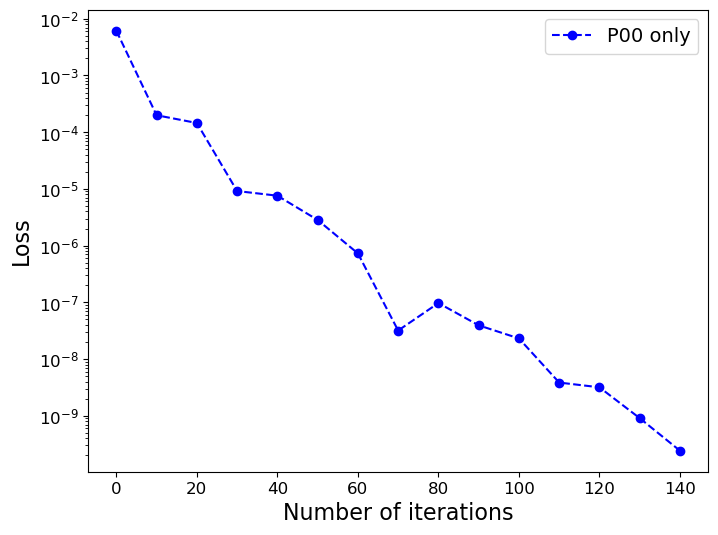

In [39]:
nit1 = 150
nit2 = 0
step = 10

plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, nit1, step), loss_history[:int(nit1/step)], 'bo--', label='P00 only')
#plt.plot(np.arange(nit1, nit1 + nit2, step), loss_history[int(nit1/step):], 'ro--', label='All coeffs')
#plt.plot(loss_history, 'bo--')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')
plt.legend()

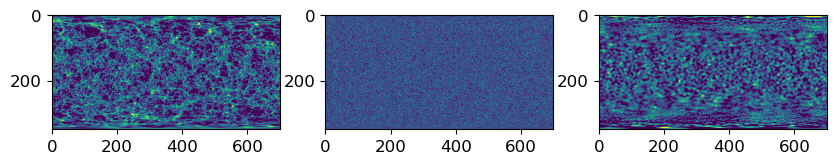

In [40]:
#mn, mx = np.nanmin(f_target), np.nanmax(f_target)
mn, mx = -1, 3
#mn, mx = None, None

fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
ax1.imshow(np.real(f_target), vmax=mx, vmin=mn, cmap='viridis')
ax2.imshow(np.real(f_start), vmax=mx, vmin=mn, cmap='viridis')
ax3.imshow(np.real(f_end), vmax=mx, vmin=mn, cmap='viridis')
plt.show()

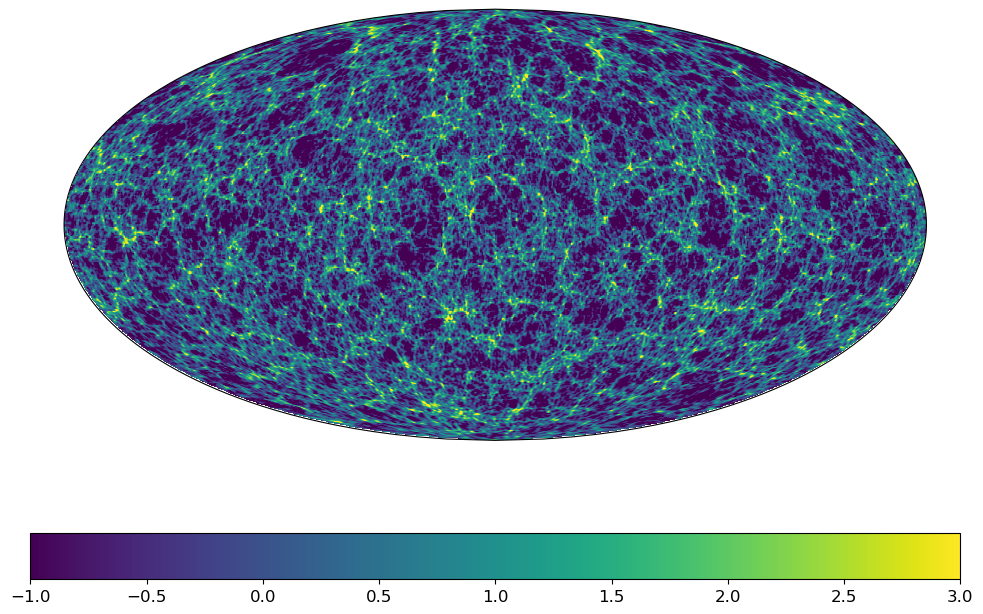

In [41]:
plot.plot_map_MW_Mollweide(f_target, vmin=mn, vmax=mx, title='')#f'Target - {mn=:.2f}, {mx=:.2f}', figsize=(12, 6))

<IPython.core.display.Javascript object>


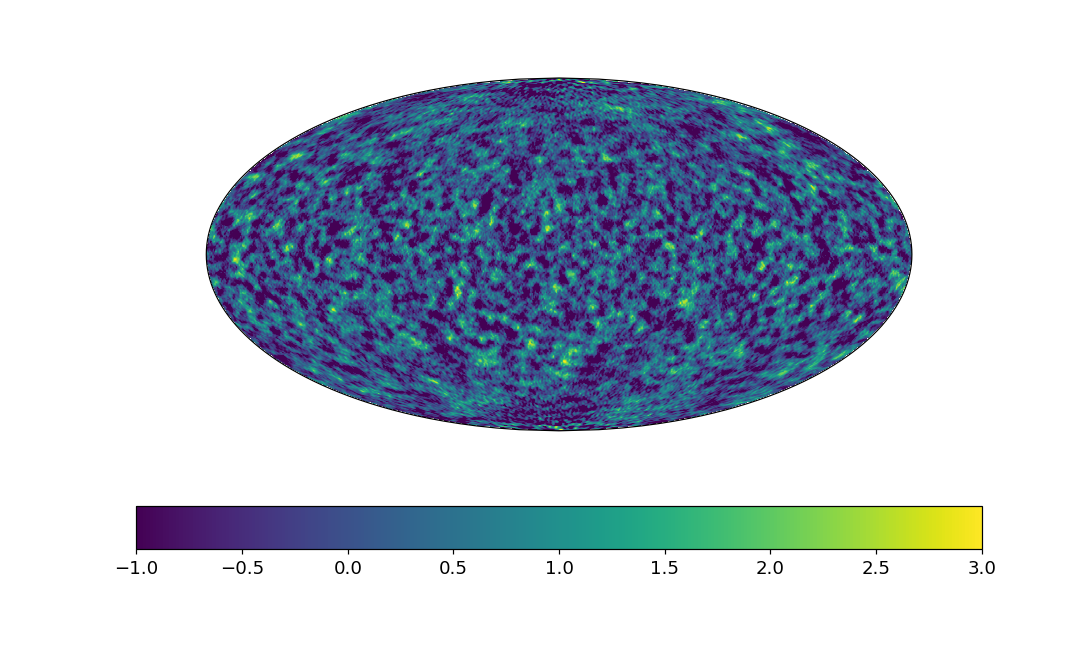

In [47]:
plot.plot_map_MW_Mollweide(f_end, vmin=mn, vmax=mx, title='', figsize=(10, 6))#f'End - {mn=:.2f}, {mx=:.2f}', )

### Power spectrum

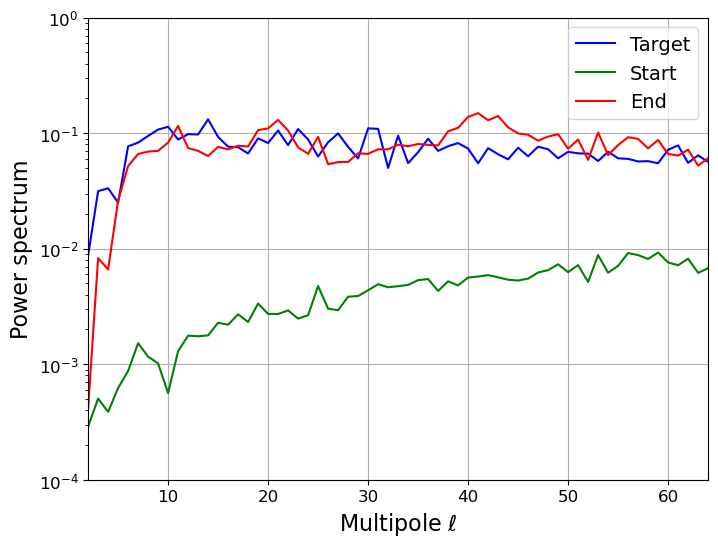

In [43]:
ps_target = sphlib.compute_ps(flm_target)
ps_start = sphlib.compute_ps(flm_start)
ps_end = sphlib.compute_ps(flm_end)

plt.figure(figsize=(8, 6))
plt.plot(ps_target, 'b', label="Target")
plt.plot(ps_start, 'g', label="Start")
plt.plot(ps_end, 'r', label="End")
plt.yscale("log")
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
plt.xlim(2, 64)
plt.ylim(1e-4, 1)
plt.legend()

### Plot the coefficients

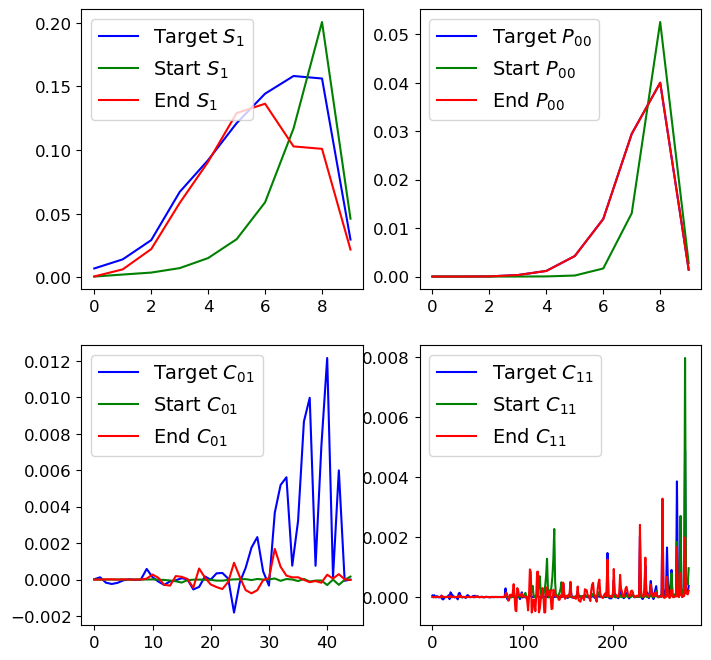

In [45]:
plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=True, color='blue')

plot.plot_scatcov_coeffs(sS1, sP00, sC01, sC11, name='Start', hold=False, color='green')

plot.plot_scatcov_coeffs(eS1, eP00, eC01, eC11, name='End', hold=False, color='red')